# Tutorial part 1

In this first part, we'll look at the ``PfLine`` class.

## Imports and example data

We start by importing the package. In this tutorial we will always be using the ``pf`` alias. We also import ``pandas`` with its common alias ``pd``.

In [2]:
import portfolyo as pf
import pandas as pd

For real-life applications, our input data will likely be a ``pandas.Series`` or ``pandas.DataFrame``, read from an Excel workbook, database, or other data service. Before this data can be used, it must often be "standardized" so that it has a certain format. That is not part of this tutorial; see [this section](../specialized_topics/dataprep.rst) for more information on standardizing input data.

In order to get some data "to play with", ``portfolyo`` has a few mockup-functions which we will use in this tutorial. Let's get some example data for 2024 in daily resolution, as a ``pandas.Series``:

In [3]:
index = pd.date_range('2024', freq='D', periods=366)
ts_offtake = -1 * pf.dev.w_offtake(index)
ts_offtake

c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pint_pandas\pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


2024-01-01    -109.24528776556488
2024-01-02     -120.8198883332017
2024-01-03    -116.59897097978185
2024-01-04    -120.08909380687946
2024-01-05     -118.7559590712826
                     ...         
2024-12-27    -118.65980731390971
2024-12-28    -111.71711544924803
2024-12-29     -97.14834408635163
2024-12-30    -110.22829465107333
2024-12-31    -118.38900547664728
Freq: D, Name: w, Length: 366, dtype: pint[MW]

The "w" in ``w_offtake`` indicates that the timeseries has *power* values, which we can also see by the ``dtype == "pint[MW]"``. See [this section on dimensions and units](../specialized_topics/dimensions.rst) for more information.

(If our data source provides timeseries of floats, i.e., without a unit, we can explicitly set the unit with ``.astype("pint[MW]")``.)

Sign conventions are a touchy subject for portfolio managers; in this case, the function returns positive values, and we flip the sign to indicate that this volume *leaves* the portfolio.

## My first portfolio line

One of the main classes defined by ``portfolyo`` is the ``PfLine`` (portfolio line). 

### Initialisation

We can initialise one with the offtake timeseries by passing it as a dictionary value. The corresponding key ``"w"`` indicates that we are dealing with power values:

In [4]:
offtake = pf.PfLine({"w": ts_offtake})
offtake

PfLine object with volume information.
. Timestamps: first: 2024-01-01 00:00:00     timezone: None
               last: 2024-12-31 00:00:00         freq: <Day> (366 datapoints)
. Children: none

                                     w           q
                                    MW         MWh

2024-01-01 00:00:00             -109.2      -2 622
2024-01-02 00:00:00             -120.8      -2 900
2024-01-03 00:00:00             -116.6      -2 798
2024-01-04 00:00:00             -120.1      -2 882
2024-01-05 00:00:00             -118.8      -2 850
2024-01-06 00:00:00             -110.7      -2 657
2024-01-07 00:00:00             -100.8      -2 420
2024-01-08 00:00:00             -111.3      -2 671
2024-01-09 00:00:00             -120.2      -2 886
2024-01-10 00:00:00             -119.5      -2 869
..                                  ..          ..
2024-12-23 00:00:00             -110.7      -2 656
2024-12-24 00:00:00             -117.1      -2 811
2024-12-25 00:00:00             -118.9 

There are 3 kinds of portfolio line. The one above is a volume-only portfolyo line, and this volume is shown both as power ``w`` in [MW] and as energy ``q`` in [MWh].

We can create a similar portfolio line containing price-only data:

In [5]:
ts_prices = pf.dev.p_marketprices(index)
prices = pf.PfLine({'p': ts_prices})

The third kind is a price-and-volume portfolio line. We can create this, either directly (e.g. by initialising a ``PfLine`` with a dictiory having both an ``'q'`` and ``'r'`` key), or through arithmatic (see below).

Let's have a look at some of the features of the ``PfLine`` class.

### Plotting

A good first look at the data is graphically. For this we can use the ``.plot()`` method:

c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pandas\core\dtypes\cast.py:1981: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pint_pandas\pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


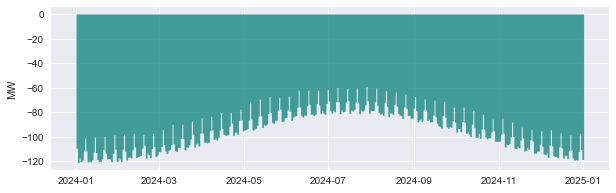

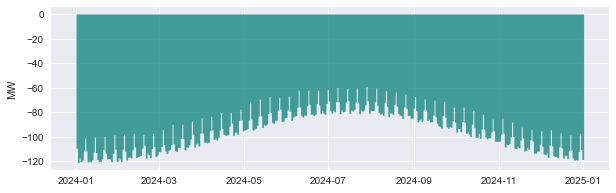

In [6]:
offtake.plot()

### Resampling

Often we will want to aggregate the data to another frequency. For this we can use the ``.asfreq()`` method, e.g., to get quarterly values:

In [7]:
prices.asfreq('QS')

PfLine object with price information.
. Timestamps: first: 2024-01-01 00:00:00     timezone: None
               last: 2024-10-01 00:00:00         freq: <QuarterBegin: startingMonth=1> (4 datapoints)
. Children: none

                                    p
                              Eur/MWh

2024-01-01 00:00:00            120.90
2024-04-01 00:00:00             82.44
2024-07-01 00:00:00             78.99
2024-10-01 00:00:00            117.56

(``portfolyo`` ensures that the values are aggregated correctly. In this case, the price (``p``) values are weighted-averaged (weighted with the duration of each datapoint - in this case a uniform 24h). See [Resampling](../specialized_topics/resampling.rst) for more information.)

The argument ``"QS"`` specifies that we want quarterly values. The allowed values, in decreasing duration, are in the ``pf.FREQUENCIES`` constant (``"15T"`` means quarterhourly):

In [8]:
pf.FREQUENCIES

['AS', 'QS', 'MS', 'D', 'H', '15T']

### Extracting data

If we want to extract the data in a portfolio line, we have several options.

Firstly, we can obtain well-known ``pandas.Series``, with the properties ``.w``, ``.q``, ``.p``, ``.r``. For the offtake portfolio line, only ``.w`` and ``.q`` return non-NaN-values; for the price portfolio line, it is only ``.p``:

In [9]:
prices.p

c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pint_pandas\pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


2024-01-01    134.47496375578058
2024-01-02    133.29093392195819
2024-01-03    129.28921635861454
2024-01-04    125.48318601110948
2024-01-05     124.7388613599846
                     ...        
2024-12-27    123.37095664514214
2024-12-28    126.24882933415036
2024-12-29    130.58180253056403
2024-12-30    133.10705904093814
2024-12-31    131.92302920711575
Freq: D, Name: p, Length: 366, dtype: pint[Eur/MW/h]

As can be seen from the data type, this series includes the unit (using the ``pint`` package), but this can be easily stripped with ``.pint.m``, returning a plain timeseries of floats.

We can also obtain a ``pandas.DataFrame`` with the ``.df()`` method. Here too the unit is included. In this case, it can be stripped (and inserted as a column level) with ``.pint.dequantify()``, as demonstrated here:

In [10]:
offtake.df().pint.dequantify()

,w,q
unit,MW,MW·h
2024-01-01,-109.245288,-2621.886906
2024-01-02,-120.819888,-2899.677320
2024-01-03,-116.598971,-2798.375304
2024-01-04,-120.089094,-2882.138251
2024-01-05,-118.755959,-2850.143018
...,...,...
2024-12-27,-118.659807,-2847.835376
2024-12-28,-111.717115,-2681.210771
2024-12-29,-97.148344,-2331.560258


Finally, we can export the data to an Excel workbook with the ``.to_excel()`` method, or copy it to the clipboard (to be pasted into e.g. Excel) with the ``.to_clipboard()`` method:

In [11]:
offtake.to_clipboard()

## Arithmatic with portfolio lines

We can do arithmatic with portfolio line. For details on what is possible and which are the return values, see the table [here](../core/pfline.rst#operations-arithmatic). 

A useful function is ``pf.Q_()``, which returns a single ``pint.Quantity`` and understands various units:

In [12]:
pf.Q_(200.0, "MW") == pf.Q_(0.2, "GW") == pf.Q_(12.0, 'GJ/min')

True

### Adding / Subtracting fixed value

We can increase the offtake by a uniform 200 MW like so: (``-`` due to the offtake being negative.)

In [13]:
offtake - pf.Q_(0.2, 'GW')

PfLine object with volume information.
. Timestamps: first: 2024-01-01 00:00:00     timezone: None
               last: 2024-12-31 00:00:00         freq: <Day> (366 datapoints)
. Children: none

                                     w           q
                                    MW         MWh

2024-01-01 00:00:00             -309.2      -7 422
2024-01-02 00:00:00             -320.8      -7 700
2024-01-03 00:00:00             -316.6      -7 598
2024-01-04 00:00:00             -320.1      -7 682
2024-01-05 00:00:00             -318.8      -7 650
2024-01-06 00:00:00             -310.7      -7 457
2024-01-07 00:00:00             -300.8      -7 220
2024-01-08 00:00:00             -311.3      -7 471
2024-01-09 00:00:00             -320.2      -7 686
2024-01-10 00:00:00             -319.5      -7 669
..                                  ..          ..
2024-12-23 00:00:00             -310.7      -7 456
2024-12-24 00:00:00             -317.1      -7 611
2024-12-25 00:00:00             -318.9 

Alternatively, if we prefer to work with floats, we could also use a dictionary to specify the power, like so: ``offtake - {"q": 200}``. In this case, it is assumed that our value is in the default unit.

### Multiplying / Dividing with fixed factor

Likewise we can multiply the data with a factor. If the offtake increases to 120%, we get

In [1]:
offtake * 1.2

NameError: name 'offtake' is not defined

### Arithmatic using timeseries

We don't have to use uniform values: we can also use other timeseries as operands. For example, if we expect a steady increase of the offtake, we can create a timeseries like this:

In [15]:
yearfraction = (index - index[0])/(index[-1] - index[0]) # values from 0 at start of index to 1 at end
increase = pd.Series(yearfraction * 0.75, index)
increase

2024-01-01    0.000000
2024-01-02    0.002055
2024-01-03    0.004110
2024-01-04    0.006164
2024-01-05    0.008219
                ...   
2024-12-27    0.741781
2024-12-28    0.743836
2024-12-29    0.745890
2024-12-30    0.747945
2024-12-31    0.750000
Freq: D, Length: 366, dtype: float64

... which can be multiplied with the offtake in the following way, to increase the offtake with a varying percentage, that ranges from +0% on Jan 01 to +75% on Dec. 31:

c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pandas\core\dtypes\cast.py:1981: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pint_pandas\pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


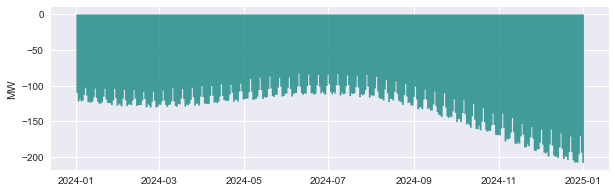

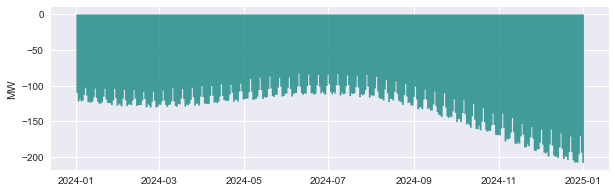

In [16]:
more_offtake = offtake * (1 + increase)
more_offtake.plot()

### Combining volume and price

We can also combine the offtake volume with a price, which gives us a price-and-volume portfolio line. We can use fixed values, like here:

In [17]:
offtake * pf.Q_(11, 'ctEur/kWh')

PfLine object with price and volume information.
. Timestamps: first: 2024-01-01 00:00:00     timezone: None
               last: 2024-12-31 00:00:00         freq: <Day> (366 datapoints)
. Children: none

                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00             -109.2      -2 622      110.00      -288 408
2024-01-02 00:00:00             -120.8      -2 900      110.00      -318 965
2024-01-03 00:00:00             -116.6      -2 798      110.00      -307 821
2024-01-04 00:00:00             -120.1      -2 882      110.00      -317 035
2024-01-05 00:00:00             -118.8      -2 850      110.00      -313 516
2024-01-06 00:00:00             -110.7      -2 657      110.00      -292 318
2024-01-07 00:00:00             -100.8      -2 420      110.00      -266 186
2024-01-08 00:00:00             -111.3      -2 671      110.00      -293 784
2024-01-09 00:00:00     

... or timeseries or other ``PfLine`` instances, like here:

In [18]:
valued_offtake = offtake * prices  # multiplying two PfLines

The resulting portfolio lines can again be resampled:

In [19]:
valued_offtake.asfreq('QS')

PfLine object with price and volume information.
. Timestamps: first: 2024-01-01 00:00:00     timezone: None
               last: 2024-10-01 00:00:00         freq: <QuarterBegin: startingMonth=1> (4 datapoints)
. Children: none

                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00             -109.9    -240 098      121.14   -29 085 413
2024-04-01 00:00:00              -85.5    -186 727       83.14   -15 524 887
2024-07-01 00:00:00              -78.4    -173 099       79.28   -13 723 753
2024-10-01 00:00:00             -103.2    -227 875      118.10   -26 912 769

Note that, even though ``prices`` and ``valued_offtake`` use the same price values at the daily resolution, the prices at quarterly resolution are slightly different. This is not an error: the prices in ``valued_offtake`` are weighted with the energy in each timestamp.

This tutorial is continued [in part 2](part2.ipynb).